In [26]:
import pandas as pd

df = pd.read_csv("../src/taxipred/data/taxi_trip_pricing.csv")
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


<Axes: >

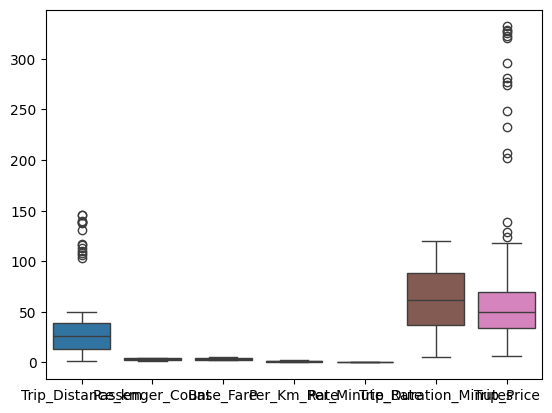

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
df_dropped = df.dropna()
df_encoded = pd.get_dummies(df_dropped, drop_first=True)

X, y = df_encoded.drop(columns="Trip_Price"), df_encoded["Trip_Price"]

sns.boxplot(df_dropped)

In [ ]:
Q1, Q3 = df_dropped["Trip_Price"].quantile(0.25), df_dropped["Trip_Price"].quantile(0.75)
# Q1, Q3 = 33.39, 67.06
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print(Q1, Q3)

df_dropped = df_dropped[(df_dropped["Trip_Price"] >= lower_bound) & (df_dropped["Trip_Price"] <= upper_bound)]

Q1, Q3 = df_dropped["Trip_Distance_km"].quantile(0.25), df_dropped["Trip_Distance_km"].quantile(0.75)
# Q1, Q3 = 33.39, 67.06
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print(Q1, Q3)

df_dropped = df_dropped[(df_dropped["Trip_Distance_km"] >= lower_bound) & (df_dropped["Trip_Distance_km"] <= upper_bound)]

sns.boxplot(df_dropped)

In [29]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42) #X_train_full använder du när du utvärderar alla modeller
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.11, random_state=42)
X_train_full.shape, X_train.shape, X_test.shape, X_val.shape, y_train_full.shape, y_train.shape, y_test.shape, y_val.shape

((505, 14), (449, 14), (57, 14), (56, 14), (505,), (449,), (57,), (56,))

In [30]:


models = {
"LinearRegression": LinearRegression(),
"RidgeCV": RidgeCV(),
"ElasticNetCV": ElasticNetCV(),
# "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=best_k),
"RandomForestRegressor": RandomForestRegressor(),
"XGBRegressor": XGBRegressor()
}
scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_val = scaler.transform(X_val)
scaled_X_train.shape, scaled_X_test.shape, scaled_X_val.shape
result = []
for key, model in models.items(): 
    model.fit(scaled_X_train, y_train)
    y_pred = model.predict(scaled_X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    # diff = y_pred[0] - y_test.iloc[0] #räkna ut diff på första[0]
    
    result.append([key, mae, mse, rmse])#, y_pred[0], y_test.iloc[0], diff])
    
df_metric = pd.DataFrame(result, columns=["model", "mae", "mse", "rmse"])
df_metric.sort_values(by="rmse")

,model,mae,mse,rmse
3,RandomForestRegressor,3.653321,22.753247,4.770036
4,XGBRegressor,3.690193,22.954100,4.791044
2,ElasticNetCV,7.170981,98.677707,9.933665
1,RidgeCV,7.560910,112.212814,10.593055
0,LinearRegression,7.563388,112.294814,10.596925
